# Preprocessing

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## 1. Dataset Prepation

import data set fom Kagglehub [Phishing Email Dataset](https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset/data)

In [11]:
import kagglehub
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")
print(f"Dataset downloaded to: {path}")


Dataset downloaded to: /home/codespace/.cache/kagglehub/datasets/naserabdullahalam/phishing-email-dataset/versions/1


In [12]:
# Load the dataset and combine them
df1 = pd.read_csv(path + "/CEAS_08.csv")
df2 = pd.read_csv(path + "/Nazario.csv")
df3 = pd.read_csv(path + "/Nigerian_Fraud.csv")
df4 = pd.read_csv(path + "/SpamAssasin.csv")
df5 = pd.read_csv(path + "/Enron.csv")
df6 = pd.read_csv(path + "/Ling.csv")
df7 = pd.read_csv(path + "/phishing_email.csv")
print("Data loaded successfully.")

# Reformat the datasets to have consistent columns and combine them
df_group1 = pd.concat([df1, df2, df3, df4], ignore_index=True)
df_group1['text'] = df_group1['subject'].fillna('') + ' ' + df_group1['body'].fillna('')
df_group1 = df_group1[['text', 'label']]
# Display the first few rows of the combined DataFrame



# Rename columns for consistency
for df_temp in [df5, df6]:
    df_temp['text'] = df_temp['subject'].fillna('') + ' ' + df_temp['body'].fillna('')
df5 = df5[['text', 'label']]
df6 = df6[['text', 'label']]

df7.rename(columns={'text_combined': 'text'}, inplace=True)

df = pd.concat([df_group1, df5, df6, df7], ignore_index=True)
df.head()
print(f"Dataset shape before cleaning: {df.shape}")



Data loaded successfully.
Dataset shape before cleaning: (164972, 2)


In [13]:
# remove rows with missing values
df.dropna(inplace=True)

# remove duplicate rows
df.drop_duplicates(inplace=True)

# reset index after dropping rows
df.reset_index(drop=True, inplace=True)

print(f"Dataset shape after cleaning: {df.shape}")



Dataset shape after cleaning: (164552, 2)


Class distribution:


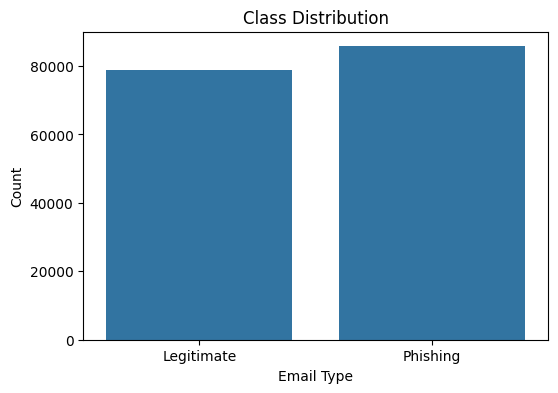

In [14]:
# Visualize the class distribution
print("Class distribution:")
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xticks([0,1], ['Legitimate', 'Phishing'])
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.show()

## 2. Data Preprocessing

### 2.1 Text Preprocessing
- Lowercasing all text
- Removing punctuation and special characters
- Removing stop words

In [15]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS  

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    # text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    
    return text

df['text'] = df['text'].apply(preprocess_text)
print("Text preprocessing completed.")

Text preprocessing completed.


Generating word clouds for phishing and legitimate emails...


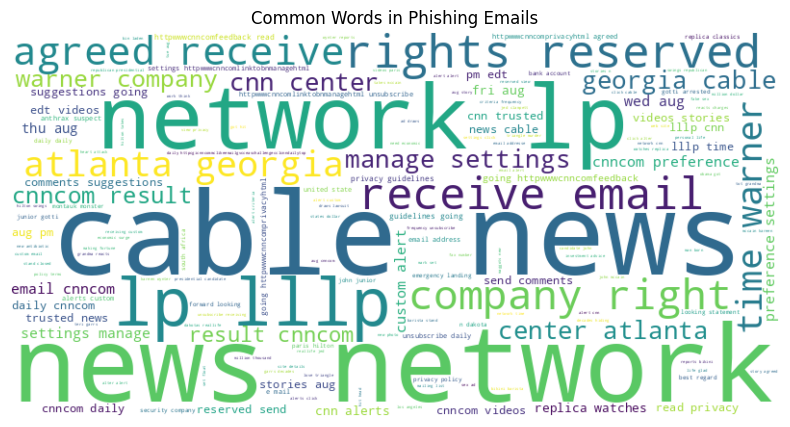

In [16]:
from wordcloud import WordCloud, STOPWORDS

print("Generating word clouds for phishing and legitimate emails...")

# For phishing emails
phishing_text = ' '.join(df[df['label']==1]['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(phishing_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Phishing Emails')
plt.show()

### 2.2 Text Vectorization & Train-Test Split

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
# Fit and transform the text data
X = vectorizer.fit_transform(df['text'])
# Extract labels
y = df['label'].values
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

Training set shape: (131641, 5000), Testing set shape: (32911, 5000)


### 3. Model Training
We are going to use baseline models as a starting point and see how the results turn out:
- Multinomial Naive Bayes
- Logistic Regression

In [23]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from  sklearn.model_selection import cross_val_score
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

print("Logistic Regression model trained and predictions made.")
print(classification_report(y_test, lr_predictions))
print(confusion_matrix(y_test, lr_predictions))
# Cross-validation for Logistic Regression
lr_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation scores: {lr_scores}")
print(f"Mean cross-validation score: {lr_scores.mean()}")


Logistic Regression model trained and predictions made.
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     15765
           1       0.98      0.99      0.99     17146

    accuracy                           0.98     32911
   macro avg       0.98      0.98      0.98     32911
weighted avg       0.98      0.98      0.98     32911

[[15463   302]
 [  213 16933]]
Cross-validation scores: [0.98481105 0.98538288 0.98337568 0.98315789 0.9854946 ]
Mean cross-validation score: 0.9844444208896856


In [24]:
# Multinomial Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)

print("Multinomial Naive Bayes model trained and predictions made.")
print(classification_report(y_test, nb_predictions))
print(confusion_matrix(y_test, nb_predictions))
# Cross-validation for Naive Bayes
nb_scores = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation scores: {nb_scores}")
print(f"Mean cross-validation score: {nb_scores.mean()}")

Multinomial Naive Bayes model trained and predictions made.
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     15765
           1       0.98      0.94      0.96     17146

    accuracy                           0.96     32911
   macro avg       0.96      0.96      0.96     32911
weighted avg       0.96      0.96      0.96     32911

[[15417   348]
 [  976 16170]]
Cross-validation scores: [0.96179076 0.96089924 0.95809007 0.95836269 0.96120978]
Mean cross-validation score: 0.9600705065616186


From the above, we can see that the **Logistic Regression** model has better performance. Therefore, we will attempt to tune it for even better results in the next step.

### 3.1 Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters for the model.

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Hyperparameter tuning for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Use the best model from grid search
best_model = grid_search.best_estimator_
best_predictions = best_model.predict(X_test)

print("Best Logistic Regression model trained and predictions made.")
print(classification_report(y_test, best_predictions))
print(confusion_matrix(y_test, best_predictions))

# Cross-validation for the best model
best_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation scores for the best model: {best_scores}")
print(f"Mean cross-validation score for the best model: {best_scores.mean()}")

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linea

Best parameters found:  {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score:  0.9913469398968247
Best Logistic Regression model trained and predictions made.
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15765
           1       0.99      0.99      0.99     17146

    accuracy                           0.99     32911
   macro avg       0.99      0.99      0.99     32911
weighted avg       0.99      0.99      0.99     32911

[[15633   132]
 [  104 17042]]
Cross-validation scores for the best model: [0.99126256 0.99224129 0.99072289 0.9902311  0.99227687]
Mean cross-validation score for the best model: 0.9913469398968247


In [ ]:
# Save the best model
import joblib
model_path = '../models/logistic_regression_model_best.pkl'
joblib.dump(best_model, model_path)
print(f"Model saved to {model_path}")

['logistic_regression_model_best.pkl']

In [ ]:
# Load the best model
import joblib
model_path = 'logistic_regression_model_best.pkl'
loaded_model = joblib.load(model_path)
print(f"Model loaded from {model_path}")

from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set using the loaded model
predictions = loaded_model.predict(X_test)

# Display the classification report and confusion matrix
print("Predictions made using the loaded model.")
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=[0, 1])

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitimate', 'Phishing'])

# Plot the confusion matrix
disp.plot()
plt.title('Confusion Matrix')
plt.show()

## References:
- Al-Subaiey, A., Al-Thani, M., Alam, N. A., Antora, K. F., Khandakar, A., & Zaman, S. A. U. (2024, May 19). Novel Interpretable and Robust Web-based AI Platform for Phishing Email Detection. ArXiv.org. https://arxiv.org/abs/2405.11619*